In [1]:
import sys
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack

import configparser

sys.path.append('/home/fabio/Desktop/poe_price')
from poe_price.learn import feature, preprocess
from poe_price.data import select

pd.set_option('display.max_columns', None)

In [2]:
conn_config = configparser.ConfigParser()
conn_config.read('/home/fabio/Desktop/poe_price/data/database/connect.ini')

['/home/fabio/Desktop/poe_price/data/database/connect.ini']

In [3]:
items = select.get_armours(conn_config['postgresql'], currency_types=['chaos', 'exalted'])

currency = select.get_currency(conn_config['postgresql'])

# Feature extraction

In [5]:
X = []
X.append(feature.corrupted(items))
# X.append(feature.duplicated(items))
# X.append(feature.identified(items))
# X.append(feature.requirements(items))
# X.append(feature.veiled(items, how='flag'))
# X.append(feature.influences(items))
X.append(feature.sockets(items))
# X.append(feature.is_abyss_jewel(items))

mods = feature.Modifiers(how='mean')
X.append(mods.fit_transform(items))

props = feature.Properties(how='mean')
X.append(props.fit_transform(items))

# categ = feature.Category()
# X.append(categ.fit_transform(items))

# subcateg = feature.SubCategories()
# X.append(subcateg.fit_transform(items))

rarity = feature.Rarity()
X.append(rarity.fit_transform(items))

In [8]:
len(X), [v.shape for v in X]

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [7]:
X = hstack(X)
X.shape, items['trade_item'].shape

((151898, 1318), (151898, 28))

In [8]:
price_transformer = feature.Price()

y = price_transformer.fit_transform(items, currency)

# Preprocessing

In [3]:
with open('/home/fabio/Desktop/poe_price/data/temp/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/home/fabio/Desktop/poe_price/data/temp/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [4]:
X.shape

(151898, 1318)

In [5]:
# coo_matrix -> csr_matrix
X = preprocess.remove_empty_features(X.tocsr())
X.shape

(151898, 1318)

In [6]:
X = X.toarray()

In [7]:
X, y = preprocess.price_bounds_row_removal(X, y, 0, 1000)
X.shape

(150384, 1318)

In [8]:
from sklearn.preprocessing import MinMaxScaler

sc_X = MinMaxScaler()
sc_y = MinMaxScaler()

X_scaled = sc_X.fit_transform(X)
y_scaled = sc_y.fit_transform(y)

In [9]:
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA

tsvd = TruncatedSVD(10, n_iter=10, random_state=42)
X_reduced = tsvd.fit_transform(X_scaled)

# pca = PCA(10, random_state=42)
# X_reduced = pca.fit_transform(X_scaled)

# kpca = KernelPCA(10, kernel='poly', degree=3, random_state=42, n_jobs=2)
# X_reduced = kpca.fit_transform(X_scaled)

### backward elimination (r2 score + p value)

In [10]:
import statsmodels.api as sm
regressor_OLS = sm.OLS(y_scaled, X_reduced).fit()
# regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.179
Model:                            OLS   Adj. R-squared (uncentered):              0.179
Method:                 Least Squares   F-statistic:                              3287.
Date:                Tue, 04 Aug 2020   Prob (F-statistic):                        0.00
Time:                        11:20:41   Log-Likelihood:                      1.2550e+05
No. Observations:              150384   AIC:                                 -2.510e+05
Df Residuals:                  150374   BIC:                                 -2.509e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0358      0.000    171.288      0.000       0.035       0.036
x2            -0.0048      0.001     -6.134      0.000      -0.006      -0.003
x3             0.0023      0.001      2.789      0.005       0.001       0.004
x4             0.0076      0.001      9.185      0.000       0.006       0.009
x5             0.0107      0.001     12.733      0.000       0.009       0.012
x6             0.0311      0.001     33.325      0.000       0.029       0.033
x7            -0.0115      0.001    -10.877      0.000      -0.014      -0.009
x8            -0.0428      0.001    -38.036      0.000      -0.045      -0.041
x9            -0.0183      0.001    -15.602      0.000      -0.021      -0.016
x10            0.0222      0.001     17.895      0.000       0.020       0.025
==============================================================================
Omnibus:                   145037.516   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5897534.776
Skew:                           4.852   Prob(JB):                         0.00
Kurtosis:                      32.103   Cond. No.                         5.93
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
def backwardElimination(x, sl):
    stats = []
    
    numVars = len(x[0])
    for i in range(0, numVars):
        a = time.time()
        
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    
        b = time.time()            
        print('[{}/{} ({}%) computed in {} seconds]: R2={}, R2_norm={}, Highets P_value:{}'.format(i, numVars, 
            round(i/numVars, 3), int(b-a), round(regressor_OLS.rsquared, 5), round(regressor_OLS.rsquared_adj, 5), 
            round(maxVar, 5)))
        stats.append((regressor_OLS.rsquared, regressor_OLS.rsquared_adj, maxVar))
        
    regressor_OLS.summary()
    return x, stats

SL = 0.05
X_clean, stats = backwardElimination(X_reduced, SL)
X_clean.shape

[0/10 (0.0%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529
[1/10 (0.1%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529
[2/10 (0.2%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529
[3/10 (0.3%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529
[4/10 (0.4%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529
[5/10 (0.5%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529
[6/10 (0.6%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529
[7/10 (0.7%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529
[8/10 (0.8%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529
[9/10 (0.9%) computed in 0 seconds]: R2=0.17938, R2_norm=0.17933, Highets P_value:0.00529


(150384, 10)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_scaled, test_size = 0.1, random_state = 0)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135345, 10), (15039, 10), (135345, 1), (15039, 1))

# Regression Models

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 

def get_metrics(y_train, y_test, y_train_pred, y_test_pred):
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    return r2_train, r2_test, mae_train, mae_test, mse_train, mse_test


## Deep learning

In [24]:
X_train.shape

(135345, 10)

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [39]:
from tensorflow.keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [41]:
model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=[coeff_determination])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1024)              11264     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 1,323,521
Trainable params: 1,323,521
Non-trainable params: 0
____________________________________________

In [42]:
history = model.fit(X_train, y_train, epochs=100, batch_size=256,  verbose=1, validation_split=0.1)

Epoch 1/100
476/476 [==============================] - 15s 31ms/step - loss: 0.0116 - coeff_determination: -0.0192 - val_loss: 0.0103 - val_coeff_determination: 0.0762
Epoch 2/100
476/476 [==============================] - 15s 31ms/step - loss: 0.0102 - coeff_determination: 0.0961 - val_loss: 0.0101 - val_coeff_determination: 0.0976
Epoch 3/100
476/476 [==============================] - 15s 31ms/step - loss: 0.0101 - coeff_determination: 0.1091 - val_loss: 0.0100 - val_coeff_determination: 0.1014
Epoch 4/100
476/476 [==============================] - 16s 33ms/step - loss: 0.0100 - coeff_determination: 0.1126 - val_loss: 0.0102 - val_coeff_determination: 0.0964
Epoch 5/100
476/476 [==============================] - 16s 33ms/step - loss: 0.0099 - coeff_determination: 0.1168 - val_loss: 0.0100 - val_coeff_determination: 0.1022
Epoch 6/100
476/476 [==============================] - 16s 33ms/step - loss: 0.0099 - coeff_determination: 0.1235 - val_loss: 0.0100 - val_coeff_determination: 0.10

KeyboardInterrupt: 

### Plotting metrics

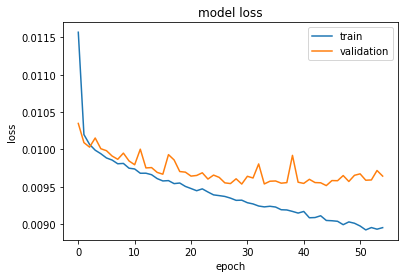

In [43]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

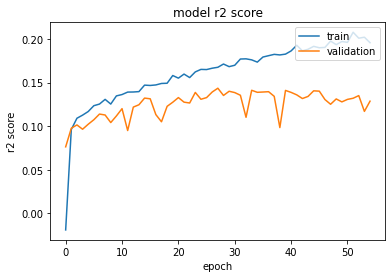

In [45]:
plt.plot(model.history.history['coeff_determination'])
plt.plot(model.history.history['val_coeff_determination'])
plt.title('model r2 score')
plt.ylabel('r2 score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [46]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [47]:
get_metrics(y_train, y_test, y_train_pred, y_test_pred)

(0.23752289664953663,
 0.14855656258874117,
 0.04159087923154546,
 0.043054162459042984,
 0.00870756768477903,
 0.009777568724413833)